# PROJET 7

## OBJECTIF DU PROJET
* Concevoir un modèle qui donnera une probabilité qu'un client fasse défaut sur un prêt
* Créer un tableau de bord à destination des chargés de clientèle qui permettra une interprétation aisée du modèle et permettra aux chargés de clientèle de mieux comprendre leurs clients
* Kenerl Kaggle de référence: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition
* Autres notebooks intéressants pour le projet:
    * https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
    * https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
    * https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics
    * https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory
    * https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
    * https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
    * https://www.kaggle.com/willkoehrsen/automated-model-tuning   
    * https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook

## LES DONNEES

Il existe 7 sources de données différentes :  

* application_train/application_test : les principales données de formation et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de la demande sont livrées avec la CIBLE indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.  

* bureau : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits précédents.  

* bureau_balance : données mensuelles sur les crédits précédents en bureau. Chaque ligne correspond à un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.  

* previous_application : précédentes demandes de crédit chez Home Credit des clients qui ont des crédits dans les données de la demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.  

* POS_CASH_BALANCE : données mensuelles sur les précédents points de vente ou crédits en espèces que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.  

* credit_card_balance : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.  

* versements_paiement : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

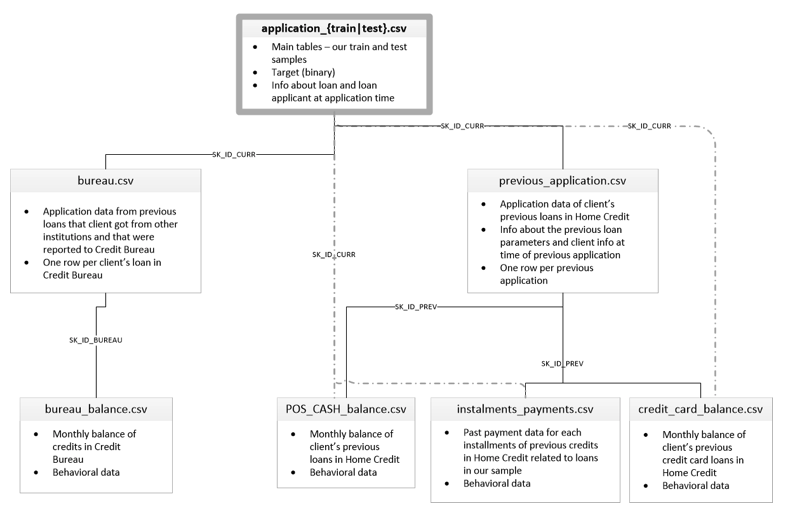

# Metric: ROC AUC
Nous allons utiliser la métrique de classification ROC AUC (Receiver Operating Characteristic Area Under The Curve).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. 
La courbe ROC représente le taux de vrais positifs par rapport au taux de faux positifs :



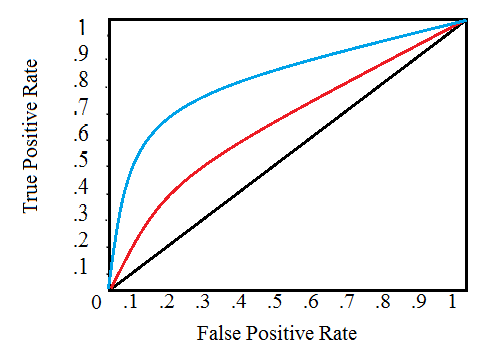

Une seule ligne sur le graphique indique la courbe d'un seul modèle, et le mouvement le long d'une ligne indique la modification du seuil utilisé pour classer une instance positive. Le seuil commence à 0 en haut à droite et passe à 1 en bas à gauche. Une courbe qui se trouve à gauche et au-dessus d'une autre courbe indique un meilleur modèle. Par exemple, le modèle bleu est meilleur que le modèle rouge, qui est meilleur que la ligne diagonale noire qui indique un modèle de devinette aléatoire naïf.

L'aire sous la courbe (AUC) s'explique par son nom ! C'est simplement l'aire sous la courbe ROC. (Il s'agit de l'intégrale de la courbe.) Cette métrique est comprise entre 0 et 1 avec un meilleur modèle notant plus haut. Un modèle qui devine simplement au hasard aura un ROC AUC de 0,5.

Lorsque nous mesurons un classificateur selon le ROC AUC, nous ne générons pas de prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut prêter à confusion car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999%, je ferais simplement un modèle qui prédira que chaque personne n'est pas un terroriste. De toute évidence, cela ne serait pas efficace (le rappel serait nul) et nous utilisons des métriques plus avancées telles que ROC AUC ou le score F1 pour refléter plus précisément les performances d'un classificateur. Un modèle avec un ROC AUC élevé aura également une grande précision, mais le ROC AUC est une meilleure représentation des performances du modèle.

Non pas que nous connaissions le contexte des données que nous utilisons et la métrique à maximiser, commençons à explorer les données. Dans ce cahier, comme mentionné précédemment, nous nous en tiendrons aux principales sources de données et aux modèles simples sur lesquels nous pourrons nous appuyer dans des travaux futurs.

## IMPORTS

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import math

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


## CHARGEMENT ET DESCRIPTION DU JEU DE DONNEES

In [2]:
os.getcwd()

'C:\\Users\\marie\\OneDrive\\OPC\\P7'

In [3]:
app_train = pd.read_csv("C:\\Users\\marie\\OneDrive\\OPC\\P7/application_train.csv")

app_test = pd.read_csv("C:\\Users\\marie\\OneDrive\\OPC\\P7/application_test.csv")


Nous n'allons pas utiliser le fichier application_test.csv (qui ne contient pas les labels)

In [4]:
from scipy import stats
def resumetable(df):
    print("df shape : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Valeurs Manquantes'] = df.isnull().sum().values 
    summary['Pourcentage Valeurs Manquantes']   = np.round((df.isnull().sum().values/df.shape[0])*100,2)
    summary['Uniques'] = df.nunique().values
    summary['Duplicated'] = df.duplicated(keep=False).sum()


    return summary

In [5]:
def describe_dataset(source_files):
    '''
        Outputs a presentation pandas dataframe for the dataset.
        Parameters
        ----------------
        sourceFiles     : dict with :
                            - keys : the names of the files
                            - values : a list containing two values :
                                - the dataframe for the data
                                - a brief description of the file
        Returns
        ---------------
        presentation_df : pandas dataframe :
                            - a column "Nom du fichier" : the name of the file
                            - a column "Nb de lignes"   : the number of rows per file
                            - a column "Nb de colonnes" : the number of columns per file
                            - a column "Description"    : a brief description of the file
    '''

    print("Les données se décomposent en {} fichier(s): \n".format(len(source_files)))

    filenames = []
    files_nb_lines = []
    files_nb_columns = []

    for filename, file_data in source_files.items():
        filenames.append(filename)
        files_nb_lines.append(len(file_data))
        files_nb_columns.append(len(file_data.columns))

    # Create a dataframe for presentation purposes
    presentation_df = pd.DataFrame({'Nom du fichier':filenames,
                                    'Nb de lignes':files_nb_lines,
                                    'Nb de colonnes':files_nb_columns})

    presentation_df.index += 1

    return presentation_df

In [6]:
describe_dataset({'App Train':app_train,
                     'App Test': app_test})

Les données se décomposent en 2 fichier(s): 



,Nom du fichier,Nb de lignes,Nb de colonnes
1,App Train,307511,122
2,App Test,48744,121


In [7]:
# Training data
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Le training set contient la target, le testing set est plus petit et ne contient pas la target, nous allons donc utiliser uniquement le trainig set

# EXPLORATY DATA ANALYSIS

## MISSING VALUES

In [8]:

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
print("{:2.2f}% des features contiennent plus de 50% de valeurs manquantes"\
.format(len(missing_values[missing_values["% of Total Values"]<50])/len(missing_values)*100))

38.81% des features contiennent plus de 50% de valeurs manquantes


Cette information sera à prendre en compte lors de l'étape de modélisation. En effet, une étape d’imputation des valeurs pourra être nécessaire pour rendre le jeu de données exploitable par certains algorithmes. Une autre option peut consister à éliminer les colonnes avec un haut pourcentage de valeurs manquantes. Nous conservons toutes les colonnes pour le moment.

## DISTRIBUTIONS

In [11]:
interesting_cols_quant = ['AMT_ANNUITY',
                          'AMT_CREDIT',
                          'AMT_GOODS_PRICE',
                          'AMT_INCOME_TOTAL',
                          'CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'DAYS_BIRTH',
                          'DAYS_EMPLOYED']

interesting_cols_qual = ['CNT_CHILDREN',
                         'CNT_FAM_MEMBERS',
                         'NAME_CONTRACT_TYPE',
                         'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS',
                         'NAME_HOUSING_TYPE',
                         'NAME_INCOME_TYPE',
                         'OCCUPATION_TYPE',
                         'ORGANIZATION_TYPE']     

interesting_cols = interesting_cols_quant + interesting_cols_qual

In [12]:
pd.concat([app_train[interesting_cols_quant].mode().T.rename(columns={0:"Mode"}),
           app_train[interesting_cols_quant].median(),
           app_train[interesting_cols_quant].mean()], axis=1)\
  .rename(columns={0:"Médiane", 1:"Moyenne"})

,Mode,Médiane,Moyenne
AMT_ANNUITY,9000.0,24903.0,27108.573909
AMT_CREDIT,450000.0,513531.0,599025.999706
AMT_GOODS_PRICE,450000.0,450000.0,538396.207429
AMT_INCOME_TOTAL,135000.0,147150.0,168797.919297
CNT_CHILDREN,0.0,0.0,0.417052
CNT_FAM_MEMBERS,2.0,2.0,2.152665
DAYS_BIRTH,-13749.0,-15750.0,-16036.995067
DAYS_EMPLOYED,365243.0,-1213.0,63815.045904


### Distribution de la colonne target

<AxesSubplot:xlabel='TARGET', ylabel='count'>

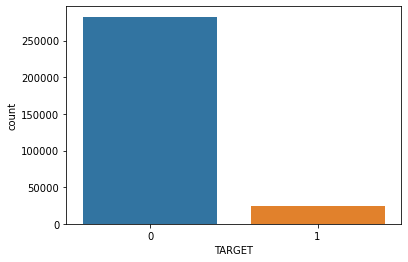

In [13]:
sns.countplot(app_train['TARGET'])

In [14]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Dans notre jeu de données, une large majorité de prêts a été remboursée.   
Il s'agit donc d'un problème présentant un déséquilibre de classes. Lors de l'étape de modélisation, il
faudra donc réfléchir à la méthodologie à employer pour obtenir un modèle performant.

### Distribution des valeurs quantitatives autres que la target

In [15]:
def plotBoxPlots(data, long, larg, nb_rows, nb_cols):
    '''
        Displays a boxplot for each column of data.
        
        Parameters
        ----------------
        data : dataframe containing exclusively quantitative data
                                 
        long : int
               The length of the figure for the plot
        
        larg : int
               The width of the figure for the plot
               
        nb_rows : int
                  The number of rows in the subplot
        
        nb_cols : int
                  The number of cols in the subplot
                                  
        Returns
        ---------------
        -
    '''

    TITLE_SIZE = 35
    TITLE_PAD = 1.05
    TICK_SIZE = 15
    TICK_PAD = 20
    LABEL_SIZE = 25
    LABEL_PAD = 10

    f, axes = plt.subplots(nb_rows, nb_cols, figsize=(long, larg))

    f.suptitle("VALEURS QUANTITATIVES - DISTRIBUTION", fontweight="bold",
              fontsize=TITLE_SIZE, y=TITLE_PAD)


    row = 0
    column = 0

    for ind_quant in data.columns.tolist():
        ax = axes[row, column]

        sns.despine(left=True)

        b = sns.boxplot(x=data[ind_quant], ax=ax, color="lightblue")

        plt.setp(axes, yticks=[])

        plt.tight_layout()

        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)

        lx = ax.get_xlabel()
        ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
        
        if ind_quant == "salt_100g":
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(float(x))))
        else:
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

        ly = ax.get_ylabel()
        ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        ax.tick_params(axis='both', which='major', pad=TICK_PAD)

        ax.xaxis.grid(True)
        ax.set(ylabel="")

        if column < nb_cols-1:
            column += 1
        else:
            row += 1
            column = 0

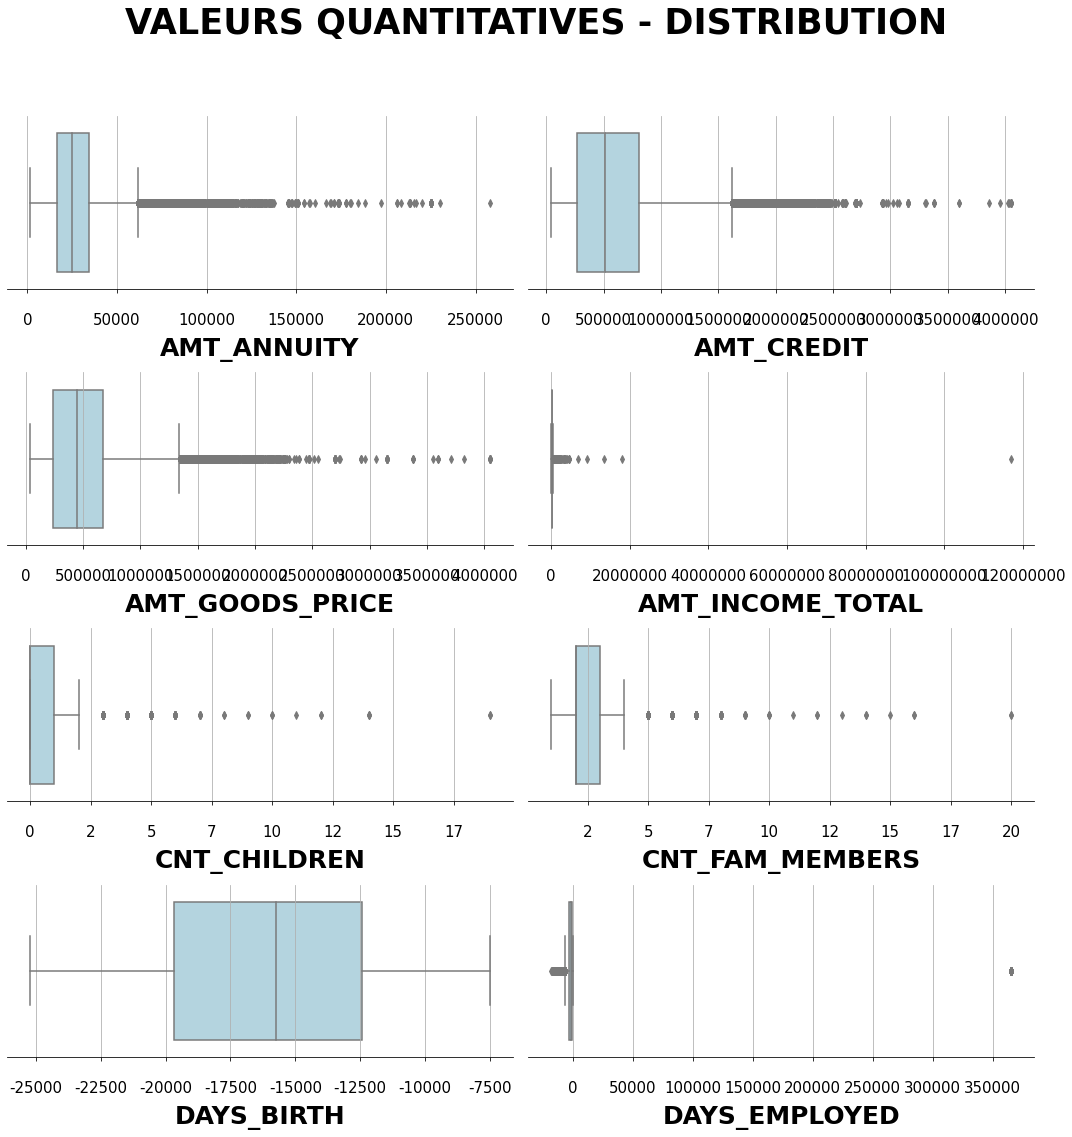

In [16]:
plotBoxPlots(app_train[interesting_cols_quant], 15, 15, 4, 2)

Un outlier ressort clairement du graphe présentant la distribution DAYS_EMPLOYED

In [17]:
def plotDistplotsWithRug(data, long, larg, nb_rows, nb_cols):
    '''
        Plots the distribution of all columns in the given
        dataframe (must be quantitative columns only) coupled
        with a rug plot of the distribution
        
        Parameters
        ----------------
        data : dataframe containing exclusively quantitative data
                                 
        long : int
               The length of the figure for the plot
        
        larg : int
               The width of the figure for the plot
               
        nb_rows : int
                  The number of rows in the subplot
        
        nb_cols : int
                  The number of cols in the subplot
                                 
        Returns
        ---------------
        -
    '''
        
    TITLE_SIZE = 30
    TITLE_PAD = 1.05
    TICK_SIZE = 15
    LABEL_SIZE = 20
    LABEL_PAD = 30

    sns.set_palette(sns.light_palette('blue', reverse=True))

    f, axes = plt.subplots(nb_rows, nb_cols, figsize=(long, larg))

    f.suptitle("DISTRIBUTION DES VALEURS QUANTITATIVES", fontweight="bold",
               fontsize=TITLE_SIZE, y=TITLE_PAD)

    row = 0
    column = 0

    for ind_quant in data.columns.tolist():

        sns.despine(left=True)

        ax = axes[row, column]

        b = sns.distplot(data[ind_quant], ax=ax, rug=True)

        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
        b.set_xlabel(ind_quant,fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        if ind_quant in ["saturated-fat_100g", "salt_100g"]:
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(float(x))))
        else:
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

        plt.setp(axes, yticks=[])

        plt.tight_layout()

        if column < nb_cols-1:
            column += 1
        else:
            row += 1
            column = 0


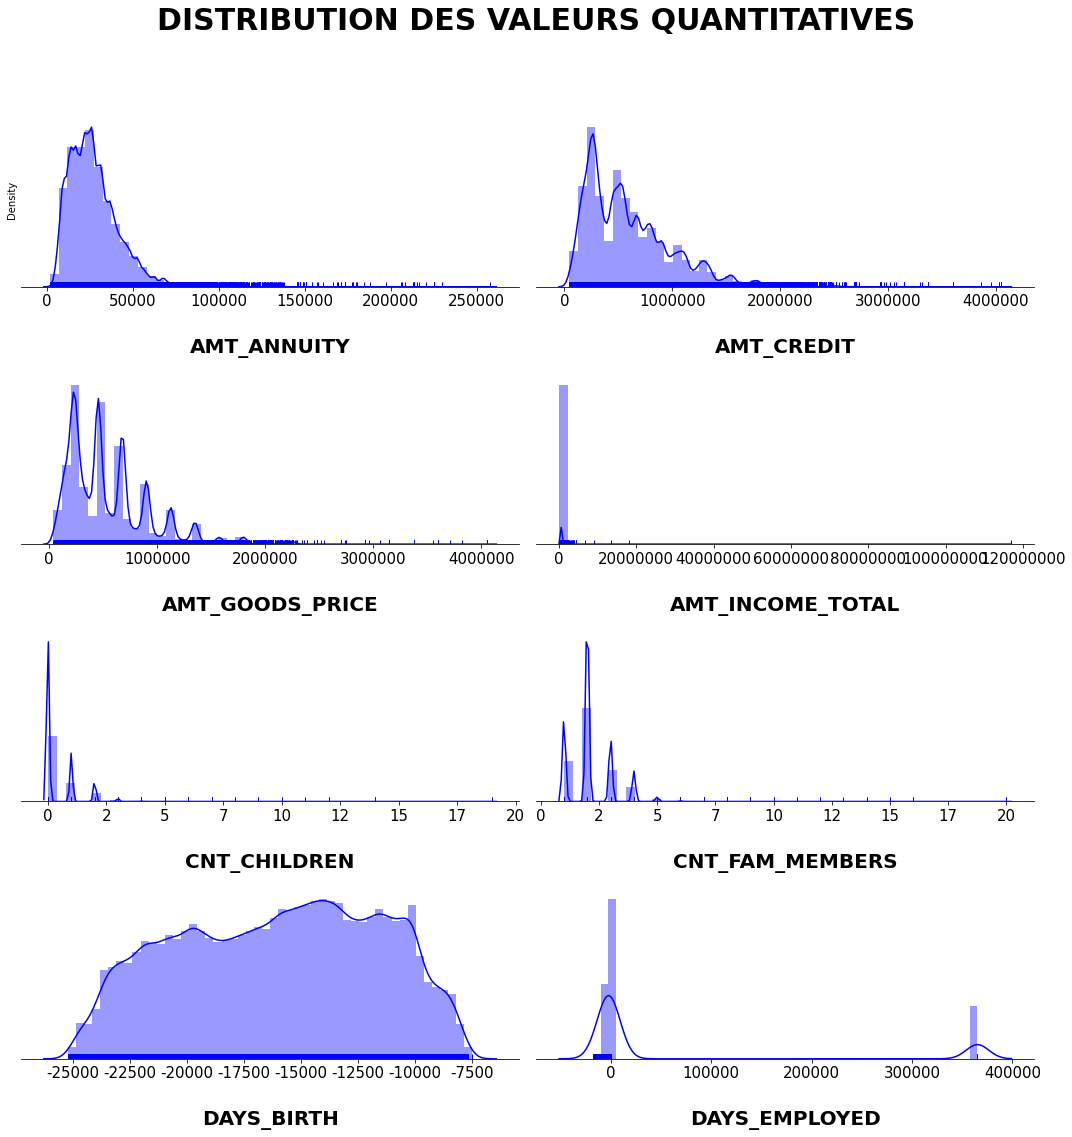

In [18]:
plotDistplotsWithRug(app_train[interesting_cols_quant], 15, 15, 4, 2)

### Distribution des valeurs qualitatives

In [19]:
def plot_qualitative_dist(data, nb_rows, nb_cols, long, larg, title):
    '''
        Displays a bar chart showing the frequency of the modalities
        for each column of data.
        Parameters
        ----------------
        data    : dataframe
                  Working data containing exclusively qualitative data
        nb_rows : int
                  The number of rows in the subplot
        
        nb_cols : int
                  The number of cols in the subplot
        long    : int
                  The length of the figure for the plot
        larg    : int
                  The width of the figure for the plot
        title   : string
                  The title to give the plot
        Returns
        ---------------
        -
    '''

    # Contants for the plot
    TITLE_SIZE = 130
    TITLE_PAD = 1.05
    TICK_SIZE = 50
    LABEL_SIZE = 100
    LABEL_PAD = 30

    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(long, larg))

    fig.suptitle("DISTRIBUTION DES VALEURS QUALITATIVES"+" "+title,
                 fontweight="bold", fontsize=TITLE_SIZE, y=TITLE_PAD)

    row = column = 0
    
    for ind_qual in data.columns.tolist():
        
        data_to_plot = data.sort_values(by=ind_qual).copy()
        
        if(nb_rows == 1 and nb_cols == 1):
            axis = axes
        elif(nb_rows == 1 or nb_cols == 1):
            if nb_rows == 1:
                axis = axes[column]
            else:
                axis = axes[row]
        else:
            axis = axes[row, column]

        plot_handle = sns.countplot(y=ind_qual,
                                    data=data_to_plot,
                                    color="lightblue",
                                    ax=axis,
                                    order=data_to_plot[ind_qual].value_counts().index)

        plt.tight_layout()

        plt.subplots_adjust(left=None,
                            bottom=None,
                            right=None,
                            top=None,
                            wspace=0.5, hspace=0.2)

        plot_handle.set_xticklabels(plot_handle.get_xticks(), size=TICK_SIZE)
    
        yticks = [item.get_text().upper() for item in axis.get_yticklabels()]
        plot_handle.set_yticklabels(yticks, size=TICK_SIZE, weight="bold")
        
        x_label = axis.get_xlabel()
        axis.set_xlabel(x_label, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        y_label = axis.get_ylabel()
        axis.set_ylabel(y_label.upper(), fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        axis.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

        axis.xaxis.grid(True)

        if column < nb_cols-1:
            column += 1
        else:
            row += 1
            column = 0


In [20]:
plot_qualitative_dist(app_train[interesting_cols_qual],3, 3, 150, 150, "")

## ANOMALIES

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [21]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les âges paraissent corrects. Il n'y a pas d'outliers pour les âges.

* Examinons de plus près les outliers repérés dans DAYS_EMPLOYED.

In [22]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [23]:
print("L'anomalie concerne {:2.2f}% des données."\
.format(len(app_train[app_train['DAYS_EMPLOYED'] == 365243])/len(app_train)*100))

L'anomalie concerne 18.01% des données.


L'anomalie concerne 18.01% des données.
On a donc ici la même valeur anormale qui concerne près de 20% des clients du jeu de données.

Il est possible que cette valeur ait une signification.

Comparons le taux de défaut des clients concernés par cette anomalie vs celui des autres.

In [24]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Les clients standard ne remboursent pas %0.2f%% des crédits.' % (100 * non_anom['TARGET'].mean()))
print('Les clients concernés par l\'anomalie ne remboursent pas %0.2f%% des crédits.'\
      % (100 * anom['TARGET'].mean()))

Les clients standard ne remboursent pas 8.66% des crédits.
Les clients concernés par l'anomalie ne remboursent pas 5.40% des crédits.


On constate que les clients concernés par cette anomalie ont un taux de défaut plus bas que les autres.

Lors de l'assemblage des données, nous remplacerons donc cette valeur anormale par NaN, mais garderons une trace de sa présence via une autre colonne.

Pour l'étude des corrélations, nous allons simplement remplacer la valeur anormale par NaN.

In [25]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


## CORRELATIONS

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

.00-.19 “very weak”  
.20-.39 “weak”  
.40-.59 “moderate”  
.60-.79 “strong”  
.80-1.0 “very strong”  

In [26]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


Correlation avec la target = risque de défaut de paiement:  
Le nombre de jours d'ancienneté et l'âge ont les corrélations positives les plus fortes avec TARGET.    
DAYS_BIRTH est l'age du client en jours au moment du prêt, cet âge est en jour négatifs.  
La correlation est positive, mais la valeur de la colonne est négative, ce qui signifie que plus le clients vieillit, moins il y a de risque de défaut de remboursement de prêt (target == 0).   
Les indicateurs synthétiques ont les corrélations négatives les plus fortes avec TARGET.

## Défaut de remboursement par tranche d'âge

In [27]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

Il y a une correlation linéaire négative entre la target (défaut de paiement) et la tranche d'âge des clients: plus les clients sont agés, plus ils ont tendance à rembourser leur prêt à temps.

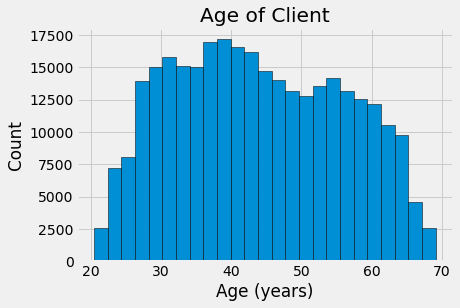

In [28]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous dit pas grand-chose à part qu'il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite faire un graphique d'estimation de la densité du noyau (KDE Kernel Density Estimation) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer un seul noyau lisse courbe). Nous utiliserons le kdeplot seaborn pour ce graphique.

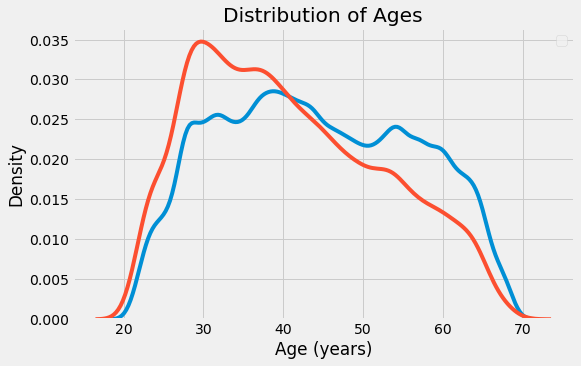

In [29]:
plt.figure(figsize = (8, 5))

# KDE plot of loans that were repaid on time
ax1= sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
ax2 =sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend([ax1, ax2], ['target == 0', 'target == 1'])

La courbe target == 1 (rouge) est biaisée vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Regardons cette relation sous un autre angle : le non-remboursement moyen des prêts par tranche d'âge.

Pour réaliser ce graphique, nous avons d'abord découpé la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque case, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

On observe que le nombre de défauts de paiement semble décroître avec l'âge.

Explorons le nombre de défauts de paiement par tranche d'âge.

In [30]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [31]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


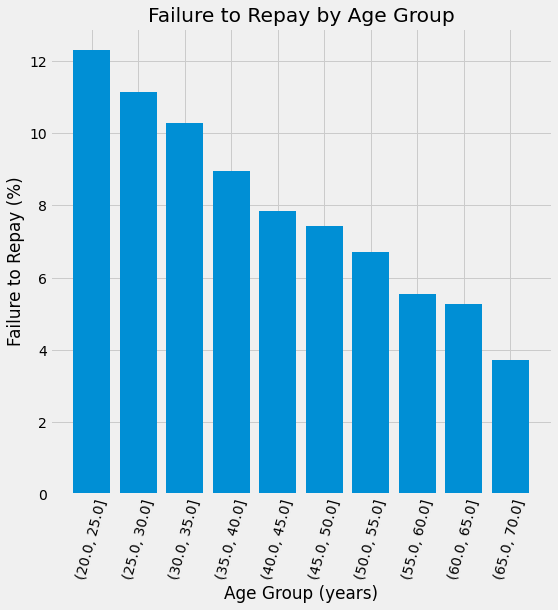

In [32]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

L'histogramme par tranche d'âge confirme nos premières observations : Le taux de défaut de remboursement est supérieur à 10% pour les tranches d'âges les plus basses, et inférieur à 5% pour les trois tranches d'âge les plus élevées.

Il s'agit d'informations qui pourraient être directement utilisées par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il faudrait peut-être leur fournir plus de conseils ou de conseils de planification financière. Cela ne signifie pas que la banque doit discriminer les clients plus jeunes, mais il serait judicieux de prendre des mesures de précaution pour aider les clients plus jeunes à payer à temps.

## Exterior Sources

Les 3 variables avec les corrélations négatives les plus fortes avec la target sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un « score normalisé provenant d'une source de données externe ». Je ne sais pas exactement ce que cela signifie, mais il peut s'agir d'une sorte de cote de crédit cumulative établie à l'aide de nombreuses sources de données.

Jetons un coup d'œil à ces variables.

Premièrement, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

In [33]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


In [34]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 
                      'EXT_SOURCE_1', 
                      'EXT_SOURCE_2', 
                      'EXT_SOURCE_3', 
                      'DAYS_BIRTH']]

ext_data_corrs = ext_data.corr("spearman")

In [35]:
def plot_correlation_heatmap(data, long, larg):
    '''
        Plots a heatmap of the Spearman correlation coefficients
        between the quantitative columns in data
        
        ----------------
        - data : a dataframe containing the data
        - long : int
                 The length of the figure for the plot
        
        - larg : int
                 The width of the figure for the plot
        
        Returns
        ---------------
        _
    '''
    
    TITLE_SIZE = 20
    TITLE_PAD = 1
    TICK_SIZE = 10
    LABEL_SIZE = 20
    LABEL_PAD = 20
    
    f, ax = plt.subplots(figsize=(long, larg))
                
    f.suptitle("MATRICE DE CORRÉLATION - SPEARMAN", fontweight="bold",
               fontsize=TITLE_SIZE, y=TITLE_PAD)

    b = sns.heatmap(data, mask=np.zeros_like(data, dtype=np.bool),
                    cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax,
                    annot=data, annot_kws={"fontsize":20}, fmt=".2f")

    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    b.set_xticklabels(xlabels, size=TICK_SIZE, weight="bold")
    b.set_xlabel(data.columns.name,fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    b.set_yticklabels(ylabels, size=TICK_SIZE, weight="bold")
    b.set_ylabel(data.index.name,fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    plt.show()

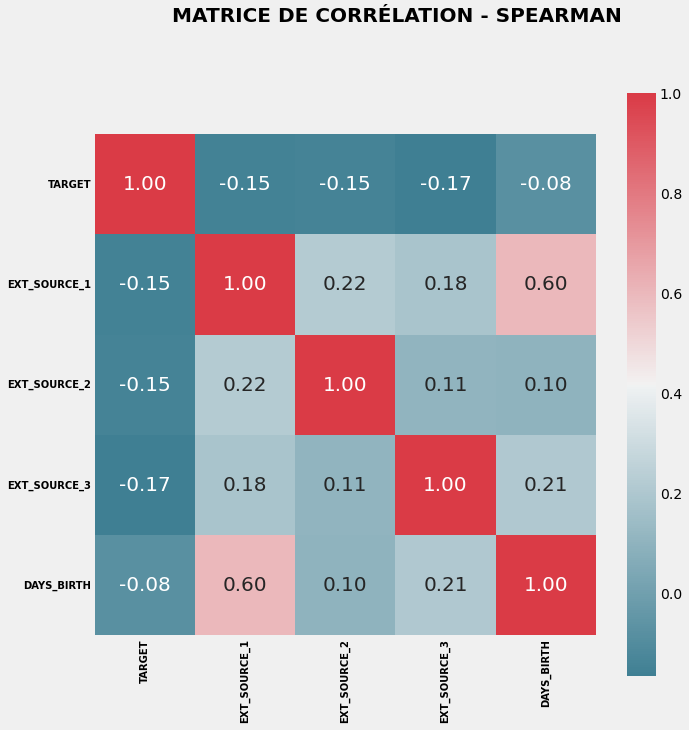

In [36]:
plot_correlation_heatmap(ext_data_corrs, 10, 10)

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la target, indiquant qu'à mesure que la valeur de EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, indiquant que l'un des facteurs de ce score est peut-être l'âge du client.
On remarque une forte corrélation négative entre l'âge et EXT_SOURCE_1.

Ensuite, nous pouvons regarder la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

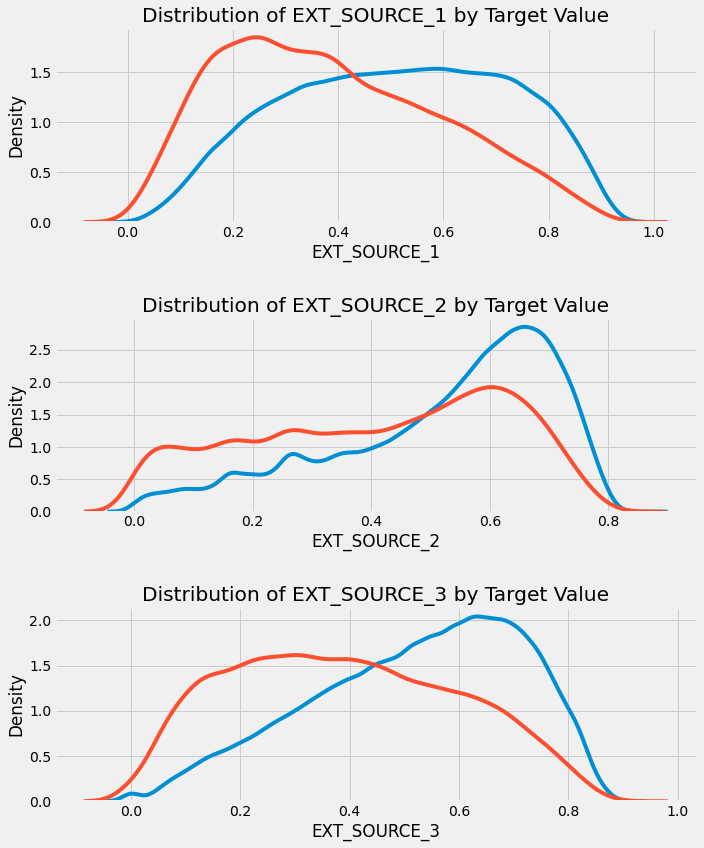

In [37]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps.

# CONCLUSION


L'analyse a pu mettre en lumière plusieurs informations importantes pour la modélisation à venir :  

* Un tiers des features du jeu de données ont 50% de valeurs manquantes.  
* Le nombre de jours d'emploi de certains clients présente la même valeur anormale  
* Des corrélations existent - bien que toutes globalement faibles - entre le taux de remboursement des crédits et certaines features du jeu de données, en particulier:  
l'âge,  
le nombre de jours d'emploi  
et les 3 indicateurs synthétiques.